In [ ]:
Імпортуємо необхідні бібліотеки

In [25]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import random
import matplotlib.pyplot as plt

In [26]:
import warnings
# Вимкнути всі попередження для видаленн зайвої інформації з консолі
warnings.filterwarnings('ignore')

In [27]:
def extract_pixel_features_rgb_with_hog(image, coordinates, hog_descriptor, window_size):
    """
    Витягує HOG-функції для кожного з каналів (R, G, B) і об'єднує їх в один вектор ознак.
    """
    features = []
    half_window = window_size // 2

    # Розбиття на колірні канали
    b_channel, g_channel, r_channel = cv2.split(image)

    for coord in coordinates:
        y, x = coord
        # Вирізаємо патчі для кожного з каналів
        patches = []
        for channel in [b_channel, g_channel, r_channel]:
            patch = channel[
                max(0, y - half_window):min(channel.shape[0], y + half_window + 1),
                max(0, x - half_window):min(channel.shape[1], x + half_window + 1)
            ]
            
            # Якщо патч менший за вказане вікно, змінюємо його розмір
            if patch.shape[0] != window_size or patch.shape[1] != window_size:
                patch = cv2.resize(patch, (window_size, window_size))
            
            patches.append(patch)

        # Витягуємо HOG-функції для кожного патчу і об'єднуємо їх
        hog_features = []
        for patch in patches:
            hog_features.extend(hog_descriptor.compute(patch).flatten())

        features.append(hog_features)  # Один об'єднаний вектор для всіх 3 каналів

    return np.array(features)

In [28]:
def prepare_data_with_colored_mask(image, mask, pixel_sample_percentage):
    """
    Вибирає підмножину координат пікселів та їх мітки для навчання,
    використовуючи кольорову маску. Ігнорує білі пікселі (255, 255, 255).
    """
    # Mapping кольорів маски на класи
    color_to_class = {
        (0, 0, 255): 0,    # Blue - Water
        (0, 255, 0): 1,    # Green - Vegetation
        (0, 0, 0): 2,      # Black - Bare soil
        (255, 255, 0): 3   # Yellow - Urban
    }

    # Висота, ширина і кількість каналів маски
    height, width, _ = mask.shape
    coordinates = []
    labels = []

    # Перетворення кольорової маски у класи
    for y in range(height):
        for x in range(width):
            b, g, r = mask[y, x]
            color = (r, g, b)  # OpenCV використовує формат BGR, тож порядок змінено
            if color in color_to_class:
                coordinates.append((y, x))
                labels.append(color_to_class[color])
            elif color == (255, 255, 255):  # Білий колір
                # Пропускаємо білий колір, бо він не несе інформації
                continue

    # Випадкове перемішування
    combined = list(zip(coordinates, labels))
    random.shuffle(combined)
    coordinates, labels = zip(*combined)

    # Вибираємо лише частину пікселів для тренування
    sample_size = int(len(coordinates) * pixel_sample_percentage)
    sampled_coordinates = coordinates[:sample_size]
    sampled_labels = labels[:sample_size]

    return sampled_coordinates, sampled_labels

In [35]:
def get_flexible_hog_params(window_size):
    """
    Генерує параметри HOG для заданого window_size.

    Parameters:
        window_size (int): Розмір обраного вікна.

    Returns:
        dict: Словник з параметрами HOG (win_size, cell_size, block_size, block_stride, nbins).
    """
    # Мінімальний розмір клітинки має бути пропорційним window_size, але не менше 2x2
    cell_size = (max(2, window_size // 2), max(2, window_size // 2))  # Сота = 2x2 або в залежності від масштабу
 
    # Розмір блоку базується на клітинці: подвійний розмір клітинки або <= window_size
    block_size = (cell_size[0] * 2, cell_size[1] * 2)  # Блок: 2x клітинка
    block_size = (min(block_size[0], window_size), min(block_size[1], window_size))  # Обмеження <= window_size

    # Крок блоку дорівнює розміру клітинки (або мінімальний 1x1 для високої деталізації)
    block_stride = cell_size

    # Кількість бінів для гістограми
    nbins = 9

    # Перевірки для забезпечення коректності налаштувань
    if block_size[0] > window_size or block_size[1] > window_size:
        raise ValueError(
            f"block_size ({block_size}) не може бути більшим за window_size ({window_size}). "
            "Збільште window_size або зменшіть block_size."
        )

    if block_size[0] % cell_size[0] != 0 or block_size[1] % cell_size[1] != 0:
        raise ValueError(
            f"block_size ({block_size}) має бути кратним cell_size ({cell_size}). "
            "Змініть налаштування клітинок або блоку."
        )

    if window_size % block_stride[0] != 0 or window_size % block_stride[1] != 0:
        raise ValueError(
            f"window_size ({window_size}) має бути кратним block_stride ({block_stride}). "
            "Змініть stride або window_size."
        )

    # Повертаємо налаштовані параметри
    return {
        "win_size": (window_size, window_size),     # Розмір вікна
        "cell_size": cell_size,                    # Розмір клітинки
        "block_size": block_size,                  # Розмір блоку
        "block_stride": block_stride,              # Крок блоку
        "nbins": nbins                             # Кількість бінів гістограми
    }

In [40]:
def classify_pixels_with_hog_and_colored_mask(image, mask, window_size=16, pixel_sample_percentage=0.2):
    """
    Класифікація пікселів із використанням HOG-функцій для RGB-каналів та кольорової маски.
    """
    print(f"Window size is set to: {window_size}x{window_size}")

    # Отримуємо HOG-параметри для заданого window_size
    hog_params = get_flexible_hog_params(window_size)
    hog_descriptor = cv2.HOGDescriptor(
        hog_params["win_size"],      # Розмір вікна
        hog_params["block_size"],    # Розмір блока
        hog_params["block_stride"],  # Крок блока
        hog_params["cell_size"],     # Розмір клітинки
        hog_params["nbins"]          # Кількість бінів
    )

    # Підготовка даних
    print("Preparing data...")
    sampled_coordinates, sampled_labels = prepare_data_with_colored_mask(image, mask, pixel_sample_percentage)

    # Витягуємо HOG-функції для кожної координати
    print("Extracting HOG features for RGB channels...")
    features = extract_pixel_features_rgb_with_hog(image, sampled_coordinates, hog_descriptor, window_size)

    # Конвертуємо мітки в numpy масив
    labels = np.array(sampled_labels)

    # Розділяємо дані на тренувальну та тестову вибірку
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.8, random_state=42)

    # Тренуємо XGBoost модель
    print("Training XGBoost classifier...")
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=4,  # Кількість класів у масці
        n_estimators=100,
        max_depth=6,
        eta=0.3
    )
    model.fit(X_train, y_train)

    # Прогнозуємо на тестовій вибірці
    print("Making predictions...")
    y_pred = model.predict(X_test)

    # Оцінюємо точність
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Класифікуємо все зображення
    print("Classifying the entire image...")
    height, width = image.shape[:2]
    full_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            # Вирізаємо патч для RGB-каналів
            patches = []
            for channel in cv2.split(image):
                patch = channel[
                    max(0, y - window_size // 2):min(channel.shape[0], y + window_size // 2 + 1),
                    max(0, x - window_size // 2):min(channel.shape[1], x + window_size // 2 + 1)
                ]

                # Якщо патч менший за зазначений розмір вікна
                if patch.shape[0] != window_size or patch.shape[1] != window_size:
                    patch = cv2.resize(patch, (window_size, window_size))

                patches.append(patch)

            # Обчислюємо HOG для кожного каналу
            hog_features = []
            for patch in patches:
                hog_features.extend(hog_descriptor.compute(patch).flatten())

            # Передбачаємо клас для поточного пікселя
            prediction = model.predict(np.array([hog_features]))[0]

            # Реконструюємо кольори класів
            class_to_color = {
                0: (0, 0, 255),    # Blue - Water
                1: (0, 255, 0),    # Green - Vegetation
                2: (0, 0, 0),      # Black - Bare soil
                3: (255, 255, 0)   # Yellow - Urban
            }

            full_mask[y, x] = class_to_color[prediction]

    return full_mask

Window size is set to: 8x8
Preparing data...
Extracting HOG features for RGB channels...
Splitting data...
Training XGBoost classifier...
Making predictions...
Accuracy: 77.45%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      2887
           1       0.70      0.15      0.24      2397
           2       0.73      0.76      0.75      7765
           3       0.78      0.90      0.84     11077

    accuracy                           0.77     24126
   macro avg       0.78      0.66      0.67     24126
weighted avg       0.77      0.77      0.75     24126

Classifying the entire image...


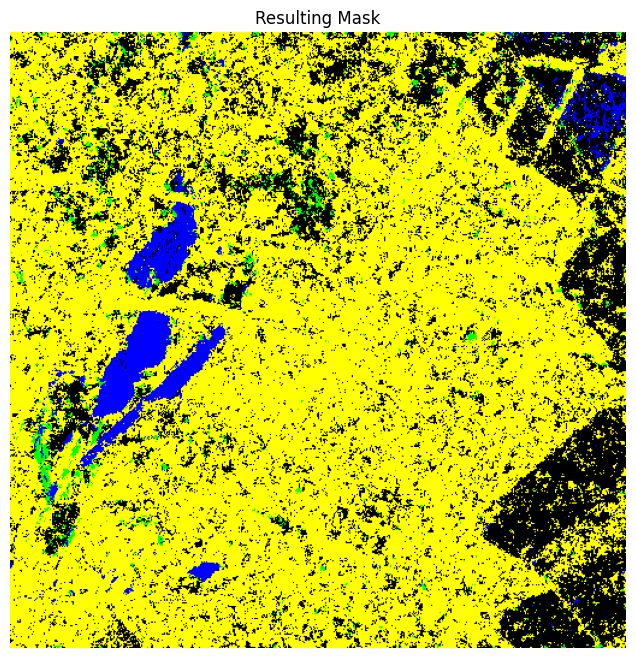

In [46]:
# Example usage
if __name__ == "__main__":
    # Завантаження зображення та маски
    image_path = "Images/sentinel/SS2/SS2.bmp"
    mask_path = "Images/sentinel/SS2/Etalon2.bmp"

    # Читаємо зображення та маску
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    # Встановлюємо розмір вікна
    window_size = 8  # Наприклад, 5x5
    resulting_mask = classify_pixels_with_hog_and_colored_mask(rgb_image, mask, window_size=window_size, pixel_sample_percentage=0.5)

    # Convert from BGR to RGB before saving
    resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)
    
    # Збереження згенерованої маски
    cv2.imwrite("Images/temp/result_colored_mask.png", resulting_mask_rgb)

    # Відображення маски в Jupyter Notebook
    plt.figure(figsize=(8, 8))  # Розмір вікна
    plt.imshow(resulting_mask)  # Відображає зображення у форматі RGB
    plt.axis('off')  # Вимикаємо осі для більш чистого вигляду
    plt.title("Resulting Mask")  # Назва зображення
    plt.show()  # Показує зображення

### **Коротке пояснення коду**

1. **Що відбувається в коді:**
   - **Витяг локальних ознак з вікон навколо пікселів:** Для кожного пікселя зображення ми вирізаємо невеликий патч (локальне вікно), розмір якого можна налаштувати (`window_size`). На основі цього патчу ми обчислюємо HOG-функції, які описують локальну текстуру.
   - **Вибірка підмножини пікселів:** Для тренування моделі ми випадковим чином обираємо частину пікселів (`pixel_sample_percentage`) і використовуємо їх мітки з маски.
   - **Тренування класифікатора:** XGBoost навчається предиктувати категорії для пікселів, аналізуючи витягнуті HOG-функції.
   - **Побудова класифікованої маски:** Після тренування класифікатор прогнозує класи для кожного пікселя та створює нову маску для всього зображення.

---

2. **Структура основних функцій:**
   - `extract_pixel_features_with_hog`: Витягує HOG-функції для заданих пікселів на основі локального вікна (`window_size`).
   - `prepare_data_with_window`: Формує координати вибіркових пікселів та їх мітки.
   - `classify_pixels_with_hog_and_window`: Керує всіма етапами: витягу функцій, тренування XGBoost, прогнозування для тестової вибірки та класифікації всього зображення.

---

### **Як змінювати код:**

1. **Змінити розмір вікна:**
   Змінюйте значення параметра `window_size` при виклику функції `classify_pixels_with_hog_and_window`. Наприклад:
   ```python
   window_size = 7  # Для більшого вікна навколо кожного пікселя
   ```
   Це вплине на те, як витягуються локальні ознаки HOG (більші вікна означають більше текстурних інформацій).

2. **Кількість вибіркових пікселів:**
   Змінюйте значення `pixel_sample_percentage` (наприклад, 0.1 для 10% вибраних пікселів):
   ```python
   pixel_sample_percentage = 0.1  # Використовувати меншу частину пікселів для тренування
   ```

3. **Змінити характеристики XGBoost:**
   Ви можете змінити параметри моделі XGBoost у функції:
   ```python
   model = xgb.XGBClassifier(
       objective='multi:softmax', 
       num_class=4,  # Кількість класів у масці
       n_estimators=150,  # Збільшити кількість дерев
       max_depth=8,  # Збільшити глибину дерева
       eta=0.2  # Регулювати швидкість навчання
   )
   ```

4. **Формат виходу:**
   Збережіть результат класифікованої маски в іншому форматі або змініть шлях у функції `cv2.imwrite`:
   ```python
   cv2.imwrite("result_mask.tiff", resulting_mask)  # Збереження результату в форматі TIFF
   ```

5. **Розширення вибірки пікселів:**
   Якщо потрібно тренувати модель на всіх пікселях (без вибірки), змініть функцію `prepare_data_with_window`:
   ```python
   sampled_coordinates = coordinates  # Використовувати всі координати
   ```

---

### **Основні параметри для модифікації:**

| **Параметр**         | **Опис**                                               | **Значення за замовчуванням** |
|-----------------------|-------------------------------------------------------|--------------------------------|
| `window_size`         | Розмір локального патчу навколо пікселя для HOG       | `5`                           |
| `pixel_sample_percentage` | Відсоток вибраних пікселів для тренування           | `0.2`                         |
| `num_class`           | Кількість класів у масці                              | `4`                           |
| `n_estimators`        | Кількість дерев в XGBoost-класифікаторі              | `100`                         |
| `max_depth`           | Максимальна глибина дерев у моделі                   | `6`                           |

---

# Задача

